<p style="align: center;"><img src="https://raw.githubusercontent.com/dimkablin/SegmentationSM/master/src/logo2.jpg", width=550, height=300></p>

<h1 style="text-align: center;"><b>Backend SM</b></h1>
<h2 style="text-align: center;"><b>Поиск архитекутуры для сегментации объекта для проекта SM </b></h2>

In [1]:
import os
from LookGenerator.config.config import DatasetConfig

config = DatasetConfig(os.environ)
config.show_details()

DATASET_DIR
BACKGROUND_DATASET


In [2]:
print(config.BACKGROUND_DATASET, "--", config.DATASET_DIR)

 -- C:\Users\dimka\PycharmProjects\data\zalando-hd-resized\


## Инициализируем датасет и dataloader

In [3]:
from torchvision.transforms import ToTensor, ToPILImage, PILToTensor
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
from typing import Tuple
import cv2
import random

from PIL import Image
from torch.utils.data import Dataset

from LookGenerator.networks.segmentation import UNet
import albumentations
import torchvision.transforms as transforms
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks.losses import FocalLossBin
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks_training.utils import check_path_and_creat

Напишем датасет, который будет в себе хранить названия всех файлов и загружать их в методе \_\_getitem__()

In [10]:
class OblDataset(Dataset):
    """ Dataset for Segmentation upper body """

    def __init__(self,
                 image_root: str,
                 mask_root: str,
                 mask_layer: int = 0,
                 image_extension="jpg",
                 transform_input=None,
                 transform_output=None,
                 augment=None):
        """
        Args:
            image_root (str) : path to images
            mask_root (str) : images directory name
            image_extension (str) : extension of any file
            mask_layer (int) : mask color !!!NEED REFUCKTOR!!!
        """
        #TODO: mask_layer form 1-d array to 3-d array.
        super().__init__()

        self.image_root = image_root
        self.mask_root = mask_root
        self.mask_layer = mask_layer
        self.image_extension = image_extension

        self.transform_input = transform_input
        self.transform_output = transform_output
        self.augment = augment

        names_of_files = os.listdir(self.image_root)
        self._files_list = [name.split('.')[0] for name in names_of_files]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Opening image by index that considered self.names_of_files variable

        Args:
            idx: The index of data sample

        Returns:
            Return torch.Tensor that represent image
                   torch.Tensor that represent mask
        """

        _image = Image.open(os.path.join(
                self.image_root,
                self._files_list[idx])
                    + "." + self.image_extension
            )
        _image = PILToTensor()(_image) / 255.0

        hsv_min = np.array((0, 0, 127), np.uint8)
        hsv_max = np.array((0, 0, 128), np.uint8)
        _mask = cv2.imread(os.path.join(
                self.mask_root,
                self._files_list[idx])
                    + "." + self.image_extension, cv2.IMREAD_COLOR)
        _mask = cv2.medianBlur(_mask, 45)
        _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2HSV)
        _mask = cv2.inRange(_mask, hsv_min, hsv_max)

        _mask = torch.from_numpy(_mask)
        _mask = _mask.unsqueeze(0)
        # _mask = Image.open(os.path.join(
        #         self.mask_root,
        #         self._files_list[idx])
        #             + "." + self.image_extension
        #     )



        # _mask = PILToTensor()(_mask)
        #
        # _mask = torch.where(_mask[0] == self.mask_layer, 1, 0)

        if self.augment:
            transformed = self.augment(image=_image,
                                       mask=_mask)
            _image = transformed['image']
            _mask = transformed['mask']

        if self.transform_input:
            _image = self.transform_input(_image)

        if self.transform_output:
            _mask = self.transform_output(_mask)

        return _image, _mask

    def __get_files_list__(self):
        """
        Returning list of file

        Returns:
            list with names of files
        """

        return self._files_list

    def __len__(self):
        """
        Return count of files

        Return:
            length of self._files_list
        """

        return len(self._files_list)


Передадим ему путь к исходным фотографиям X и маске Y

In [11]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [12]:
transform_image = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.RandomBrightnessContrast(brightness_limit=(0.1,0.3), contrast_limit=(0.2,0.7), p =0.2),
        albumentations.Equalize(p = 0.2),
        albumentations.GaussNoise(p = 0.2),
        albumentations.Affine(translate_percent=0.1, scale=(0.8, 1), rotate=(-90,90), p=0.2),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

transform_mask = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

In [13]:
train_dataset = OblDataset(image_root=os.path.join(config.DATASET_DIR, "train", "image"),
                           mask_root=os.path.join(config.DATASET_DIR, "train", "agnostic-v3.2"),
                           mask_layer=128,
                           image_extension="jpg",
                           # transform_input=transform_input,
                           transform_output=transform_output)

val_dataset = OblDataset(image_root=os.path.join(config.DATASET_DIR, "test", "image"),
                         mask_root=os.path.join(config.DATASET_DIR, "test", "agnostic-v3.2"),
                         mask_layer=128,
                         image_extension="jpg",
                         transform_input=transform_input,
                         transform_output=transform_output)

Проверим его корректность работы и выведем парочку

In [14]:
import matplotlib.pyplot as plt

def _print(image, mask):
    fig = plt.figure(figsize=(20, 14))

    fig.add_subplot( 1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))

    fig.add_subplot( 1, 2, 2)
    plt.imshow(mask[0], cmap='gray')

tensor([[[0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8980, 0.8980],
         [0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8980, 0.8980],
         [0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8980, 0.8980]],

        [[0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8980, 0.8980],
         [0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8980, 0.8980],
         [0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8980, 0.8980]],

        [[0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.8627, 0.8627,  ..., 0.8824, 0.8824, 0.

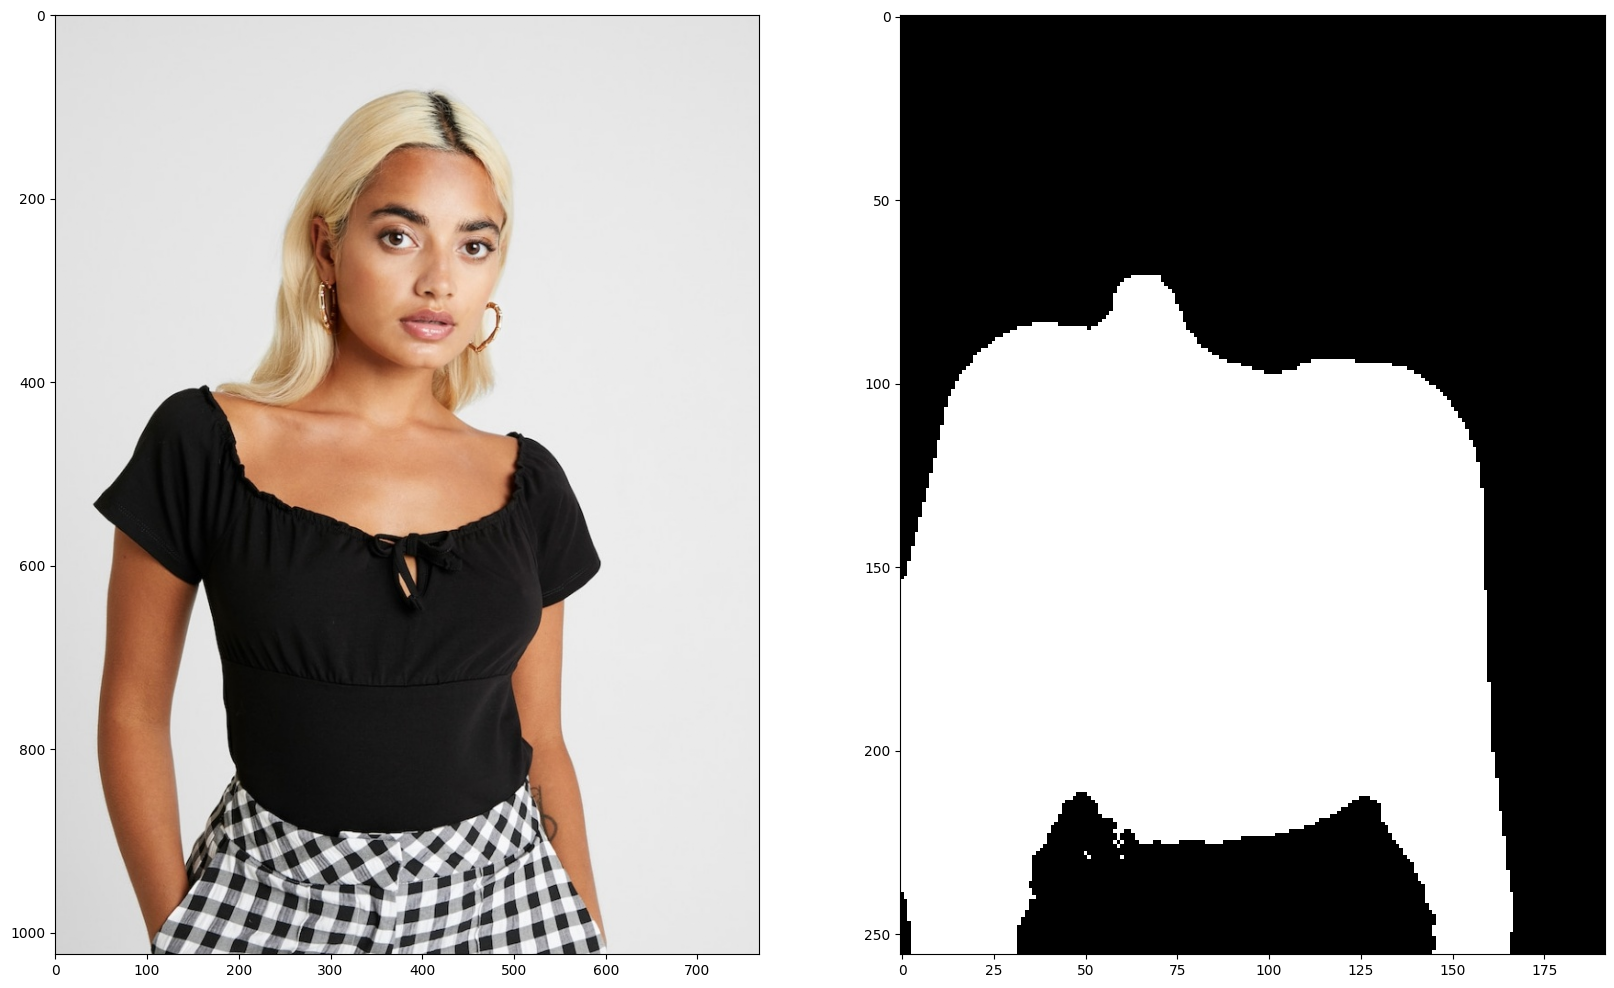

In [15]:
number = np.random.randint(0, 11647)


image, mask = train_dataset.__getitem__(number)
print(image, mask.size(), number)
_print(image, mask)


Поделим датасет на тренировочную, валидационную и тестовую

In [67]:
batch_size_train = 32
batch_size_val = 32
pin_memory = True
num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)


## Реализируем основной цикл обучения

# Обучение

## Architectures
### 1. our Unet

In [69]:
model_unet = UNet(in_channels=3, out_channels = 1)

In [70]:
#model = load_model(model, r'')                 # активировать, если модель надо загрузить и дообучить
optimizer = torch.optim.Adam(model_unet.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossBin()

In [71]:
save_directory = r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmetationBackground\weights\testResults"
check_path_and_creat(save_directory)


True

In [72]:
epoch_num = 3

In [73]:
trainer = Trainer(
    model_=model_unet, optimizer=optimizer, criterion = criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [74]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

start time 18-05-2023 22:25


  0%|          | 0/364 [00:00<?, ?it/s]


TypeError: image must be numpy array type

In [ ]:
trainer.draw_history_plots()

### Визуальная проверка результатов

In [ ]:
def check_losses(model_, dataloader_, **loss_fns_):
    model_.eval()

    losses = { key : 0 for key in loss_fns_.keys() }

    for x_batch, y_batch in dataloader_:
        y_pred = model_(x_batch)

        for name, loss_fn in loss_fns_.items():
            loss = loss_fn(y_batch, y_pred)
            losses[name] += loss.item() * len(x_batch)

    for name, loss in losses.item():
        losses[name] /= len(dataloader_)

    return losses

def plot_results(model_, dataloader_):
    for x_batch, y_batch in dataloader_:
        y_hat = model_(x_batch)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(x_batch[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(y_hat[k, 0], cmap='gray')
            plt.title('output')
            plt.axis('off')
        plt.show()
        break

### 2. SegNet

In [ ]:
import torch.nn as nn

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck

        self.b_conv_enc = nn.Sequential(
             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU()
             )

        self.b_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.b_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.b_conv_dec = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
             nn.BatchNorm2d(256),
             nn.ReLU()
             )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        size0 = x.size() # torch.Size([25, 3, 256, 256])

        e0, indices0 = self.pool0(self.enc_conv0(x))
        size1 = e0.size() # torch.Size([25, 8, 128, 128])

        e1, indices1 = self.pool1(self.enc_conv1(e0))
        size2 = e1.size() # torch.Size([25, 16, 64, 64])

        e2, indices2 = self.pool2(self.enc_conv2(e1))
        size3 = e2.size() # torch.Size([25, 32, 32, 32])

        e3, indices3 = self.pool3(self.enc_conv3(e2))
        size4 = e3.size() # torch.Size([25, 64, 16, 16])

        # bottleneck
        b1, bottle_id = self.b_pool( self.b_conv_enc(e3))
        b1_size = b1.size()

        b3 = self.b_conv_dec(self.b_unpool(b1, bottle_id, output_size=size4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b3, indices3, output_size=size3))
        d1 = self.dec_conv1(self.upsample1(d0, indices2, output_size=size2))
        d2 = self.dec_conv2(self.upsample2(d1, indices1, output_size=size1))
        d3 = self.dec_conv3(self.upsample3(d2, indices0, output_size=size0))  # no activation
        return d3

## 3. a few Unet's arhc